<a href="https://colab.research.google.com/github/victor-hro/movie-recommender/blob/main/heur%C3%ADsticas_e_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Recomendação de Filmes

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Conjunto de dados: MovieLens

### download

In [4]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2021-12-22 22:47:17--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip.2’

ml-latest-small.zip 100%[===================>] 955.28K  4.62MB/s    in 0.2s    

2021-12-22 22:47:18 (4.62 MB/s) - ‘ml-latest-small.zip.2’ saved [978202/978202]

Archive:  ml-latest-small.zip
replace ml-latest-small/links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [5]:
df_movies = pd.read_csv('/content/ml-latest-small/movies.csv')
df_ratings = pd.read_csv('/content/ml-latest-small/ratings.csv')

In [6]:
# utilizando o próprio ID do filme como índice
df_movies.set_index('movieId', inplace=True)
df_movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [7]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# Primeira Heurística: recomendação dos filmes mais populares

## Distribuição de frequência de notas

In [8]:
total_ratings = df_ratings['movieId'].value_counts()

In [9]:
# agrupando por índice
df_movies['total_ratings'] = total_ratings
df_movies

,title,genres,total_ratings
movieId,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215.0
2,Jumanji (1995),Adventure|Children|Fantasy,110.0
3,Grumpier Old Men (1995),Comedy|Romance,52.0
4,Waiting to Exhale (1995),Comedy|Drama|Romance,7.0
5,Father of the Bride Part II (1995),Comedy,49.0
...,...,...,...
193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,1.0
193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,1.0
193585,Flint (2017),Drama,1.0


In [10]:
# analisando do maior para o menor número de votos
df_movies.sort_values('total_ratings', ascending=False).head(10)

,title,genres,total_ratings
movieId,,,
356,Forrest Gump (1994),Comedy|Drama|Romance|War,329.0
318,"Shawshank Redemption, The (1994)",Crime|Drama,317.0
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,307.0
593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,279.0
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,278.0
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,251.0
480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,238.0
110,Braveheart (1995),Action|Drama|War,237.0
589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,224.0


Poderíamos até indicar esses 10 filmes para qualquer pessoa, baseando apenas na heurística de recomendação de filmes mais votados. Porém há um problema nessa análise: os filmes podem ter um maior número de votos, mas as notas também são boas?

Outra questão é relacionada ao comportamento em grupos de internet. Pode haver a possibilidade de comunidades de um nicho se unirem para votar em determinado filme, subindo ele para a lista de mais votados.

In [11]:
# agrupando por notas
average_ratings = df_ratings.groupby('movieId').rating.mean()
average_ratings

movieId
1         3.920930
2         3.431818
3         3.259615
4         2.357143
5         3.071429
            ...   
193581    4.000000
193583    3.500000
193585    3.500000
193587    3.500000
193609    4.000000
Name: rating, Length: 9724, dtype: float64

In [12]:
df_movies['average_ratings'] = average_ratings
df_movies['average_ratings'] = df_movies['average_ratings'].apply(lambda x: round(x,2))
df_movies.head()

,title,genres,total_ratings,average_ratings
movieId,,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215.0,3.92
2,Jumanji (1995),Adventure|Children|Fantasy,110.0,3.43
3,Grumpier Old Men (1995),Comedy|Romance,52.0,3.26
4,Waiting to Exhale (1995),Comedy|Drama|Romance,7.0,2.36
5,Father of the Bride Part II (1995),Comedy,49.0,3.07


In [13]:
# analisando do maior para o menor número de votos, agora com as notas
top_10_most_voted = df_movies.sort_values('total_ratings', ascending=False).head(10)
top_10_most_voted

,title,genres,total_ratings,average_ratings
movieId,,,,
356,Forrest Gump (1994),Comedy|Drama|Romance|War,329.0,4.16
318,"Shawshank Redemption, The (1994)",Crime|Drama,317.0,4.43
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,307.0,4.20
593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,279.0,4.16
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,278.0,4.19
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,251.0,4.23
480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,238.0,3.75
110,Braveheart (1995),Action|Drama|War,237.0,4.03
589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,224.0,3.97


<Figure size 576x432 with 0 Axes>

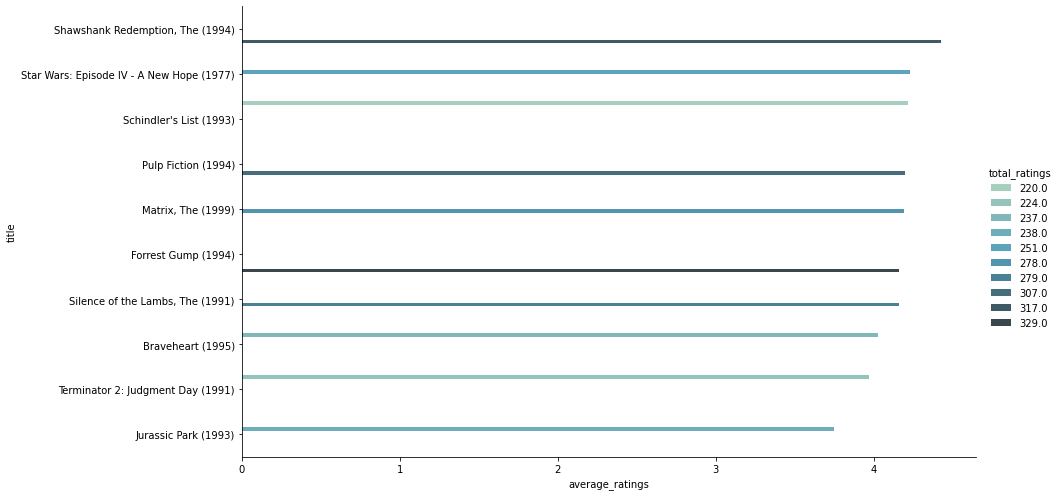

In [14]:
# agrupando as 10 maiores notas
plt.figure(figsize=(8,6))
sns.catplot(
    data=top_10_most_voted[['title','total_ratings', 'average_ratings']],
    x='average_ratings',
    y='title',
    kind='bar',
    orient='h',
    palette='GnBu_d',
    aspect=2,
    height=7,
    hue='total_ratings',
    order = top_10_most_voted[['title', 'total_ratings', 'average_ratings']].sort_values('average_ratings', ascending=False).title.values
)

podemos ver que filmes como o Jurassic Park foram bem votados, porém não apresentam uma nota tão alta como os demais.
Schindler's List foi um dos filmes menos populares em votos e teve uma das maiores notas médias.

# Segunda Heurística: recomendação dos filmes com maior nota média.

In [15]:
df_movies.sort_values('average_ratings', ascending=False).head(10)

,title,genres,total_ratings,average_ratings
movieId,,,,
69860,Eichmann (2007),Drama|War,1.0,5.0
145994,Formula of Love (1984),Comedy,1.0,5.0
141816,12 Chairs (1976),Adventure|Comedy,1.0,5.0
26366,Harlan County U.S.A. (1976),Documentary,1.0,5.0
95311,Presto (2008),Animation|Children|Comedy|Fantasy,1.0,5.0
5088,"Going Places (Valseuses, Les) (1974)",Comedy|Crime|Drama,1.0,5.0
95175,Front of the Class (2008),Drama,1.0,5.0
26401,Last Hurrah for Chivalry (Hao xia) (1979),Action|Drama,1.0,5.0
5059,Little Dieter Needs to Fly (1997),Documentary,1.0,5.0


Há um grande problema em utilizar essa heurística. Não podemos definir que um filme é muito bom apenas pelo valor da nota média. Estamos vendo que, para nota 5, os top 10 filmes tiveram apenas 1 voto.

Outra hipótese que podemos levar em conta é relacionada ao nicho de cada filme. Talvez o filme pode ser tão específico para um nicho que poucas pessoas votam, porém podem votar com notas altas.

possível solução: vamos filtrar o total de votos por um valor N para ter um melhor controle dessa métrica:

In [16]:
ratings_over_50 = df_movies.query("total_ratings >= 50").sort_values('average_ratings', ascending=False)
ratings_over_50

,title,genres,total_ratings,average_ratings
movieId,,,,
318,"Shawshank Redemption, The (1994)",Crime|Drama,317.0,4.43
858,"Godfather, The (1972)",Crime|Drama,192.0,4.29
750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,97.0,4.27
1276,Cool Hand Luke (1967),Drama,57.0,4.27
2959,Fight Club (1999),Action|Crime|Drama|Thriller,218.0,4.27
...,...,...,...,...
172,Johnny Mnemonic (1995),Action|Sci-Fi|Thriller,53.0,2.68
173,Judge Dredd (1995),Action|Crime|Sci-Fi,62.0,2.67
432,City Slickers II: The Legend of Curly's Gold (...,Adventure|Comedy|Western,55.0,2.65


Ainda não parece interessante para nossos propósitos. Pode funcionar, porém também pode ter um viés relacionado ao nicho

# Terceira Heurística: recomendação baseada em similaridade de gênero comparando apenas um usuário.

dentre os filmes com votos acima de 50, vamos escolher um filme e analisar os filmes com gêneros parecidos.

Vamos supoer que escolhermos assistir algum filme do Harry Potter

In [17]:
ratings_over_50[ratings_over_50.title.str.contains('Harry Potter')]

,title,genres,total_ratings,average_ratings
movieId,,,,
8368,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX,93.0,3.91
88125,Harry Potter and the Deathly Hallows: Part 2 (...,Action|Adventure|Drama|Fantasy|Mystery|IMAX,50.0,3.91
69844,Harry Potter and the Half-Blood Prince (2009),Adventure|Fantasy|Mystery|Romance|IMAX,58.0,3.89
54001,Harry Potter and the Order of the Phoenix (2007),Adventure|Drama|Fantasy|IMAX,58.0,3.86
40815,Harry Potter and the Goblet of Fire (2005),Adventure|Fantasy|Thriller|IMAX,71.0,3.82
4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy,107.0,3.76
5816,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy,102.0,3.60


Harry Potter and the Chamber of Secrets (2002) foi escolhido

In [18]:
movies_watched = df_movies.query("title == 'Harry Potter and the Chamber of Secrets (2002)'")
movies_watched

,title,genres,total_ratings,average_ratings
movieId,,,,
5816,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy,102.0,3.6


In [19]:
adventure_fantasy = ratings_over_50.query("genres=='Adventure|Fantasy'")
adventure_fantasy.drop(movies_watched.index, errors='ignore', inplace=True)
adventure_fantasy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,title,genres,total_ratings,average_ratings
movieId,,,,
4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,198.0,4.11
5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,188.0,4.02


Quando a pessoa acaba de ver harry potter, os dois filmes de Lord of the Rings podem ser recomendados para assistir posteriormente.

# Collaborative Filtering x Content Based Filtering

## Distância euclidiana entre dois usuários

In [20]:
def euclidian_distance(a, b):
    """compute euclidian distance between two variables"""
    return np.linalg.norm(a - b)

def user_ratings(user: int):
    """returns the ratings given by the user"""
    ratings = df_ratings.query("userId == @user")[['movieId','rating']]
    ratings.set_index('movieId', inplace=True)
    return ratings

def distance_between_users(user1: int, user2: int, min=5):
    """compute euclidian distance between users"""
    ratings1 = user_ratings(user1)
    ratings2 = user_ratings(user2)
    diff = ratings1.join(ratings2, lsuffix="_left", rsuffix="_right").dropna()

    # se um usuário não viu o mesmo filme que o outro, a diferença = 0
    # iremos colocar um valor muito grande para esse caso, evitando utilizar zeros

    if len(diff) < min:
        return None

    return [user1, user2, euclidian_distance(diff['rating_left'], diff['rating_right'])]

In [21]:
# CÉLULA DE TESTE
distance_between_users(1, 5)

[1, 5, 3.7416573867739413]

vamos analisar a distância euclidiana entre dois usuários que assistem harry potter and the sorcerer's stone

In [22]:
df_movies[df_movies.title.str.contains('Harry Potter')]

,title,genres,total_ratings,average_ratings
movieId,,,,
4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy,107.0,3.76
5816,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy,102.0,3.60
8368,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX,93.0,3.91
40815,Harry Potter and the Goblet of Fire (2005),Adventure|Fantasy|Thriller|IMAX,71.0,3.82
54001,Harry Potter and the Order of the Phoenix (2007),Adventure|Drama|Fantasy|IMAX,58.0,3.86
69844,Harry Potter and the Half-Blood Prince (2009),Adventure|Fantasy|Mystery|Romance|IMAX,58.0,3.89
81834,Harry Potter and the Deathly Hallows: Part 1 (...,Action|Adventure|Fantasy|IMAX,47.0,3.99
88125,Harry Potter and the Deathly Hallows: Part 2 (...,Action|Adventure|Drama|Fantasy|Mystery|IMAX,50.0,3.91


In [23]:
df_ratings.query("movieId == 4896")

,userId,movieId,rating,timestamp
513,4,4896,4.0,1007574532
948,7,4896,4.0,1106636718
1974,18,4896,3.5,1456923934
3171,20,4896,4.5,1054037243
3359,21,4896,4.0,1418932147
...,...,...,...,...
95677,600,4896,4.0,1237713120
97253,605,4896,3.5,1277175611
98039,606,4896,4.0,1171322878
99296,608,4896,3.0,1117162371


Os usuários 4, 7 e 21 deram a mesma nota para o filme. Vamos pegá-los como exemplo

In [24]:
distance_between_users(4, 7)[-1]

5.634713834792322

In [25]:
# CÉLULA DE TESTE
ratings4 = user_ratings(4)
ratings7 = user_ratings(7)

print('Distância euclidiana entre os usuários 4 e 7:  {:.2f}'.format(distance_between_users(4, 7)[-1]))
print('Distância euclidiana entre os usuários 4 e 21: {:.2f}'.format(distance_between_users(4, 7)[-1]))
print('Distância euclidiana entre os usuários 7 e 21: {:.2f}'.format(distance_between_users(7, 21)[-1]))

Distância euclidiana entre os usuários 4 e 7:  5.63
Distância euclidiana entre os usuários 4 e 21: 5.63
Distância euclidiana entre os usuários 7 e 21: 11.38


Podemos ver que os valores aumentaram e que os usuários 7 e 21 tendem a apresentar uma maior distância euclidiana.

In [26]:
# notas dos usuários 7 e 21
users_7_and_21 = df_ratings.query('userId == 7 | userId == 21').set_index('movieId')
# unindo as informações de ambos os usuários
users_7_and_21 = users_7_and_21.merge(df_movies, on='movieId')
users_7_and_21.query('rating > 4').head()

,userId,rating,timestamp,title,genres,total_ratings,average_ratings
movieId,,,,,,,
1,7,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215.0,3.92
50,7,4.5,1106635993,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,204.0,4.24
150,7,4.5,1106635925,Apollo 13 (1995),Adventure|Drama|IMAX,201.0,3.85
260,7,5.0,1106635933,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,251.0,4.23
260,21,4.5,1417378080,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,251.0,4.23


In [27]:
# filtrando os usuários 7 e 21 com notas acima de 4
user7_top5_ratings  = users_7_and_21.query('(userId == 7)  & (rating>=4)')[['genres', 'rating']].head(5)
user21_top5_ratings = users_7_and_21.query('(userId == 21) & (rating>=4)')[['genres', 'rating']].head(5)

# concatenando as top 5 notas e gêneros de cada usuário em um dataframe
user7_user21_genres_ratings = pd.concat([user7_top5_ratings, user21_top5_ratings])
user7_user21_genres_ratings.head()

,genres,rating
movieId,,
1,Adventure|Animation|Children|Comedy|Fantasy,4.5
50,Crime|Mystery|Thriller,4.5
150,Adventure|Drama|IMAX,4.5
165,Action|Crime|Thriller,4.0
260,Action|Adventure|Sci-Fi,5.0


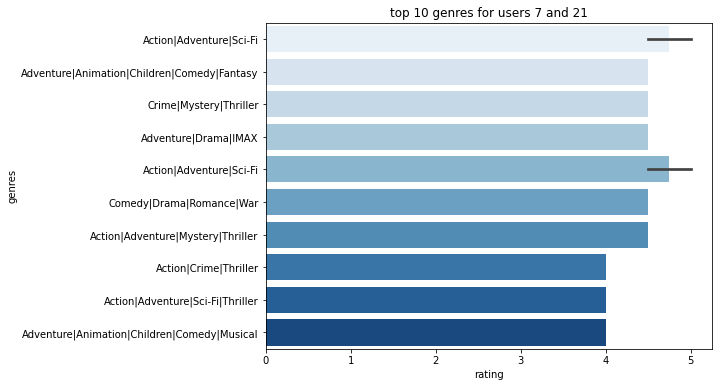

In [28]:
plt.figure(figsize=(8,6))
plt.title('top 10 genres for users 7 and 21')
sns.barplot(
    data=user7_user21_genres_ratings, 
    y ='genres', 
    x = 'rating',
    palette='Blues',
    order = user7_user21_genres_ratings.sort_values('rating', ascending=False).genres.values
)

✅ Podemos analisar que ambos gostam de filmes de ação e aventura e tem gostos bem comuns entre si.

## Distância euclidiana entre um usuário e os demais usuários

In [29]:
# usuários únicos
unique_users = df_ratings.movieId.unique()
len(unique_users)

9724

In [30]:
def all_distances(user, n_users=None):
    """
    calculates the euclidian distance between a users in relation to all others
    
    user [int]: user id
    n [int]: number of closest users.
    """
    all_users = df_ratings['userId'].unique()

    if n_users:
        # filtering by N users
        all_users = all_users[:n_users]

    distance = [distance_between_users(user, user_id) for user_id in all_users]
    distance = list(filter(None, distance)) # remove NaN

    return pd.DataFrame(distance, columns=['user', 'other_users', 'distance'])
    
def close_users(user_id, n_users=None):
    """
    get the users closest to the user_id
    
    user_id [int]: user id
    n [int]: number of closest users.
    """

    distance = all_distances(user_id, n_users=n_users)
    # remove user_id
    distance = distance.sort_values("distance", ascending=True)
    distance = distance.set_index("other_users").drop(user_id)
    return distance

In [31]:
# dentre os N primeiros usuários comparados com o usuário alvo:
# vamos escolher o usuário 1
user_id = 1
similar = close_users(user_id, n_users=50)
most_similar = similar.iloc[0].name
print('ID do usuário mais similar: %d' % most_similar)
similar.head()

ID do usuário mais similar: 49


,user,distance
other_users,,
49,1,1.000000
9,1,1.000000
25,1,1.414214
13,1,1.414214
30,1,1.802776


dado a quantidade de usuários similares, iremos pegar o primeiro:

In [32]:
print('Notas do usuário %d:' % most_similar)
user_most_similar_ratings = user_ratings(most_similar)
user_most_similar_ratings.T

Notas do usuário 49:


movieId,110,318,356,527,1097,1200,1214,2028,2571,4022,5218,6377,47099,70286,79091,79132,103335,109487,122920,139385,168252
rating,4.0,4.0,4.0,4.5,4.5,4.5,4.0,4.5,4.5,4.5,4.0,4.0,4.5,4.0,4.0,4.5,4.0,4.5,4.0,4.5,4.5


retirando os filmes que já assisti

In [33]:
# removendo da lista os filmes que o usuário 1 já viu
# se existir algum filme que o usuário 1 viu e o mais similar não viu, haverá erro no df.drop
# para isso ignoramos as mensagens de erro

watched = user_ratings(1).index
user_most_similar_ratings = user_most_similar_ratings.drop(watched, errors='ignore').sort_values('rating', ascending=False)
user_most_similar_ratings.T

movieId,1200,4022,47099,79132,109487,139385,168252,318,5218,6377,70286,79091,103335,122920
rating,4.5,4.5,4.5,4.5,4.5,4.5,4.5,4.0,4.0,4.0,4.0,4.0,4.0,4.0


In [34]:
# criando uma função para após o teste feito

def recommender_to(user_idm, n_users=50):
    watched = user_ratings(user_id).index                     # filmes assistidos
    similar = close_users(user_id, n_users=n_users)                # N usuários mais similares
    most_similar = similar.iloc[0].name                       # usuário mais similar
    user_most_similar_ratings = user_ratings(most_similar)    # notas do usuário mais similar

    # eliminando os filmes que o usuário mais similar avaliou e o user_id já assistiu
    # ordenando pela nota, de forma crescente
    recommendation = user_most_similar_ratings.drop(watched, errors='ignore').sort_values('rating', ascending=False)

    # join com o df_movies: ambos tem o filme como ID, iremos apenas registrar o título do filme em uma das colunas
    return recommendation.join(df_movies)

In [35]:
recommender_to(1, n_users=100).head()

,rating,title,genres,total_ratings,average_ratings
movieId,,,,,
8636,5.0,Spider-Man 2 (2004),Action|Adventure|Sci-Fi|IMAX,79.0,3.80
58559,5.0,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,149.0,4.24
33794,5.0,Batman Begins (2005),Action|Crime|IMAX,116.0,3.86
4993,5.0,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,198.0,4.11
5349,5.0,Spider-Man (2002),Action|Adventure|Sci-Fi|Thriller,122.0,3.54


agora vamos comparar a relação entre 5 filmes assistidos e 5 filmes recomendados

In [36]:
watched_movies_user_1 = df_movies.loc[watched[:5]]
watched_movies_user_1

,title,genres,total_ratings,average_ratings
movieId,,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215.0,3.92
3,Grumpier Old Men (1995),Comedy|Romance,52.0,3.26
6,Heat (1995),Action|Crime|Thriller,102.0,3.95
47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,203.0,3.98
50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,204.0,4.24


In [37]:
recommendations_to_user_1 = recommender_to(1, n_users=50).head(10)
recommendations_to_user_1

,rating,title,genres,total_ratings,average_ratings
movieId,,,,,
1200,4.5,Aliens (1986),Action|Adventure|Horror|Sci-Fi,126.0,3.96
4022,4.5,Cast Away (2000),Drama,100.0,3.70
47099,4.5,"Pursuit of Happyness, The (2006)",Drama,46.0,3.79
79132,4.5,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX,143.0,4.07
109487,4.5,Interstellar (2014),Sci-Fi|IMAX,73.0,3.99
139385,4.5,The Revenant (2015),Adventure|Drama,31.0,3.90
168252,4.5,Logan (2017),Action|Sci-Fi,25.0,4.28
318,4.0,"Shawshank Redemption, The (1994)",Crime|Drama,317.0,4.43
5218,4.0,Ice Age (2002),Adventure|Animation|Children|Comedy,85.0,3.69


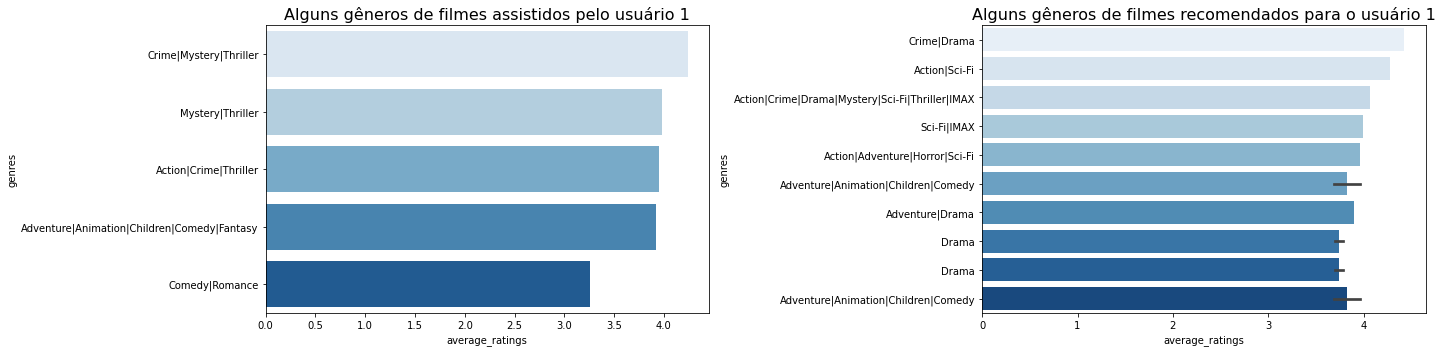

In [38]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title('Alguns gêneros de filmes assistidos pelo usuário 1', size=16)
sns.barplot(
    data=watched_movies_user_1, 
    y ='genres', 
    x = 'average_ratings',
    palette='Blues',
    order = watched_movies_user_1.sort_values('average_ratings', ascending=False).genres.values
)

plt.subplot(1,2,2)
plt.title('Alguns gêneros de filmes recomendados para o usuário 1', size=16)
sns.barplot(
    data=recommendations_to_user_1, 
    y ='genres', 
    x = 'average_ratings',
    palette='Blues',
    order = recommendations_to_user_1.sort_values('average_ratings', ascending=False).genres.values
)
plt.tight_layout()

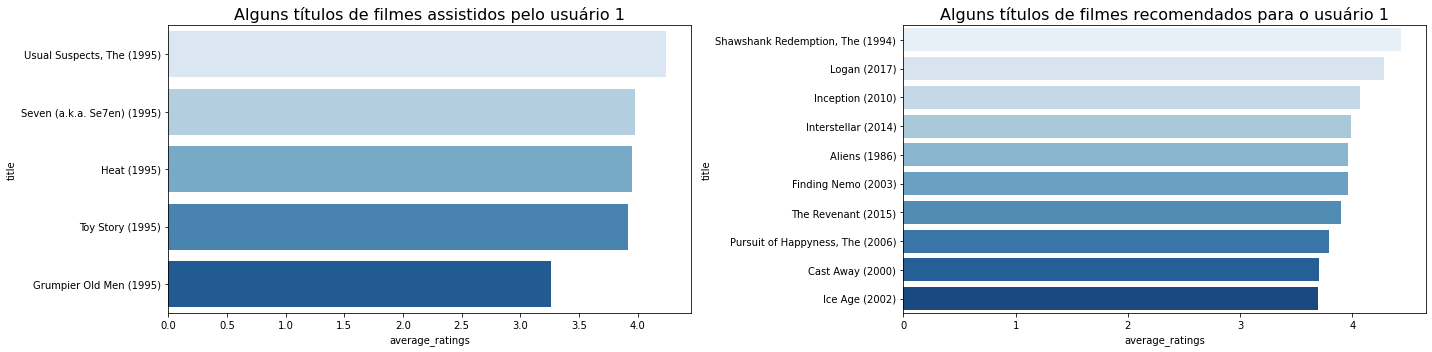

In [39]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title('Alguns títulos de filmes assistidos pelo usuário 1', size=16)
sns.barplot(
    data=watched_movies_user_1, 
    y ='title', 
    x = 'average_ratings',
    palette='Blues',
    order = watched_movies_user_1.sort_values('average_ratings', ascending=False).title.values
)

plt.subplot(1,2,2)
plt.title('Alguns títulos de filmes recomendados para o usuário 1', size=16)
sns.barplot(
    data=recommendations_to_user_1, 
    y ='title', 
    x = 'average_ratings',
    palette='Blues',
    order = recommendations_to_user_1.sort_values('average_ratings', ascending=False).title.values
)
plt.tight_layout()

Chegamos a um momento onde percebemos que o código pode ser eficiênte, porém ainda está limitado a recomendar filmes baseado apenas no usuário mais similar. O correto é expandir esse conceito e recomendar filmes baseado em filmes assistidos por várias outras pessoas, evitando focar em nichos específicos.

# Quarta Heurística: K-NN

Recomendação baseada em similaridade de gênero comparada a várias pessoas.

## Recomendação baseada em vários usuários

In [40]:
def all_distances(user, n_users=None):
    """
    calculates the euclidian distance between a users in relation to all others
    
    user [int]: user id
    n [int]: number of closest users.
    """
    all_users = df_ratings['userId'].unique()

    if n_users:
        # filtering by N users
        all_users = all_users[:n_users]

    distance = [distance_between_users(user, user_id) for user_id in all_users]
    distance = list(filter(None, distance)) # remove NaN

    return pd.DataFrame(distance, columns=['user', 'other_users', 'distance'])
    

def close_users(user_id, n_users=None, k=10):
    """
    get the users closest to the user_id
    
    user_id [int]: user id
    n [int]: number of closest users.

    k [int]: k nearest neighbors
    """

    distance = all_distances(user_id, n_users=n_users)
    distance = distance.sort_values("distance", ascending=True)
    distance = distance.set_index("other_users").drop(user_id)   # remove user_id
    return distance.head(k)


def recommender_to(user_id, n_users=50, k=10):
    """
    movies recommender
    
    user_id [int]: user id
    n [int]: number of closest users.

    k [int]: k nearest neighbors
    """
    # filmes assistidos:
    watched = user_ratings(user_id).index


    # manipulando variáveis de usuários similares:                  
    similar = close_users(user_id, n_users=n_users, k=k)      # k usuários mais similares
    similar_ratings = df_ratings.set_index("userId").loc[similar.index]  # Notas dos k usuários mais similares 
    most_similar_ratings = user_ratings(similar)              # notas do usuário mais similar
    recommendations = most_similar_ratings.groupby('movieId').mean()[['rating']]   # agrupo as notas por filmes e tiro a média das notas e seleciono como array
    recommendations = recommendations.sort_values('rating', ascending=False)       # agrupando pelas maiores notas
    # eliminando os filmes que o usuário mais similar avaliou e o user_id já assistiu
    # ordenando pela nota, de forma crescente
    # recommendation = most_similar_ratings.drop(watched, errors='ignore').sort_values('rating', ascending=False)

    # join com o df_movies: ambos tem o filme como ID, iremos apenas registrar o título do filme em uma das colunas
    return recommendations.join(df_movies)

In [ ]:
new_recommendations_to_user_1 = recommender_to(1, n_users=50, k=10)
new_recommendations_to_user_1

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3475: PerformanceWarning: Alignment difference on axis 1 is larger than an order of magnitude on term '__pd_eval_local_user', by more than 5.004; performance may suffer
  return _eval(expr, inplace=inplace, **kwargs)


In [ ]:
# plt.figure(figsize=(12,4))
# plt.subplot(1,2,1)
# plt.title('nota média das recomendações baseadas comparando apenas um usuário')
# sns.boxplot(data=recommendations_to_user_1,x='average_ratings');
# plt.subplot(1,2,2)
# plt.title('nota média das recomendações baseadas utilizando K-NN')
# sns.boxplot(data=new_recommendations_to_user_1,x='average_ratings');
# plt.tight_layout()

In [ ]:
# new_recommendations_to_user_1 = recommender_to(1, n_users=50, k=50)


# plt.figure(figsize=(12,8))
# plt.subplot(2,1,1)
# plt.title('nota média das recomendações baseadas comparando apenas um usuário')
# sns.barplot(
#     data=recommendations_to_user_1,
#     y='rating',
#     x='total_ratings',
#     order=recommendations_to_user_1.total_ratings.value_counts(ascending=True).index
#     );
# plt.subplot(2,1,2)
# plt.title('nota média das recomendações baseadas utilizando K=10')
# sns.barplot(
#     data=new_recommendations_to_user_1,
#     y='rating',
#     x='total_ratings',
#     order=new_recommendations_to_user_1.total_ratings.value_counts(ascending=True).index
#     );
# plt.tight_layout()

baseando em vários usuários podemos ver que a popularidade (total_ratings) dentre os filmes recomendados é maior. Dessa forma podemos assumir que o algoritmo possa atuar melhor em suas recomendações.